In [1]:
import numpy as np
import pandas as pd
import xlrd
import math

In [2]:
data = pd.ExcelFile("./ERK.xlsx")

In [3]:
sheets = data.sheet_names
threshold = 1.1
end_time = 30

In [4]:
l = len(sheets)
data_dict = {}
sem = {}
avg = {}
time_dict = {}

for i in xrange(l):
    
    tmp = data.parse(sheets[i])
    col = tmp.columns.values
    
    max_after = tmp.loc[(tmp[col[0]] >0) & (tmp[col[0]] <= end_time)].max()
    max_after = max_after.loc[max_after > threshold].to_frame().transpose()
    max_after[col[0]] = "max"
    
    valid_cols = max_after.columns.values

    avg4 = tmp.loc[tmp[valid_cols[0]] <= 0, tmp.columns.isin(valid_cols)]\
            .mean().to_frame().transpose()
    avg4[col[0]] = "avg"
    
    tmp = tmp.loc[tmp[col[0]] <= end_time, tmp.columns.isin(valid_cols)]\
            .append(avg4, ignore_index = True)\
            .append(max_after, ignore_index = True)

    para = max_after.append(avg4, ignore_index = True)
    para = para.append((para.ix[0, 1:] - para.ix[1, 1:]) / 2 + para.ix[1, 1:], ignore_index = True)
    para.ix[2, 0] = "threshold"
    
    tmp = tmp.append(para, ignore_index = True)
    
    time_point = {}
    for column in valid_cols[1:]:
        temp = tmp.ix[:, [valid_cols[0], column]]
        value = temp.iloc[-1, 1]
        time_point[column] = temp.loc[(temp[valid_cols[0]] > 0) & (temp[column] >= value)].iloc[0, 0]
    
    select_time = pd.DataFrame([time_point])
    tmp = tmp.append(select_time, ignore_index = True)
    tmp.iloc[-1, 0] = "first_time_point"
    
    time_dict[sheets[i]] = select_time

    data_dict[sheets[i]] = tmp
    
    std = select_time.std(axis = 1).values[0]
#     print std
    sem[sheets[i]] = std / math.sqrt(select_time.count(axis = 1).values[0])
    avg[sheets[i]] = select_time.mean(axis = 1).values[0]
    
    filename = sheets[i] + '_time_point.csv'
    select_time.to_csv(filename, sep='\t')
    
    if(i == 3):
        print select_time
    
    filename2 = sheets[i] + '_filtered_data.csv'
    
    data_dict[sheets[i]].to_csv(filename2, sep='\t')

   s10  s11   s12  s13  s14  s15  s17  s18   s2  s22 ...    s26  s37  s38  \
0  6.0  6.0  18.0  6.0  3.0  3.0  3.0  3.0  9.0  6.0 ...   12.0  9.0  3.0   

    s4   s47   s48  s49   s5   s8   s9  
0  6.0  27.0  27.0  3.0  6.0  6.0  6.0  

[1 rows x 23 columns]


In [5]:
sem

{u'KR': 0.83315667577124386,
 u'WT': 1.4293825797184645,
 u'YF': 0.60704779026755318,
 u'countrol': 0.83349679682782185}

In [6]:
avg

{u'KR': 13.232142857142858,
 u'WT': 8.0869565217391308,
 u'YF': 6.145161290322581,
 u'countrol': 12.096774193548388}

In [7]:
import numpy as np
import pylab as pl
%matplotlib inline
import matplotlib

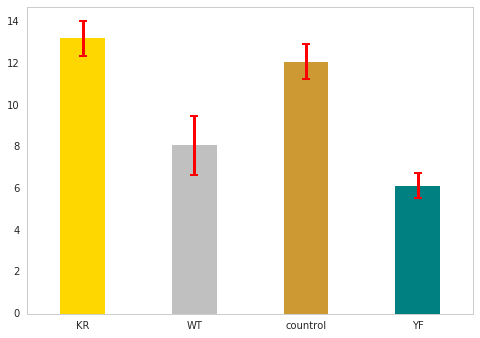

In [38]:
X = np.arange(len(avg))
pl.bar(X, avg.values(), align='center', width=0.4, yerr=sem.values(),\
        color=['#ffd700', '#c0c0c0', '#cd9932', '#008080'],\
        error_kw=dict(ecolor='red', lw=3, capsize=4, capthick=2),linewidth = 0)
pl.xticks(X, avg.keys())
ymax = max(avg.values()) + 1.5
pl.ylim(0, ymax)
# pl.xticks(rotation=45)
pl.grid(False)
# pl.figure(figsize=(20,20))
pl.show()

In [10]:
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid", palette="muted")


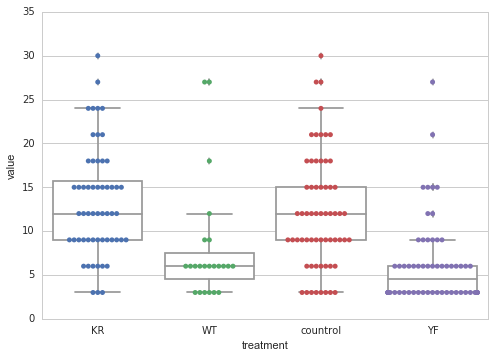

In [46]:
col = ['treatment', 'value']
time_data = pd.DataFrame(columns = col)
for key in time_dict.keys():
    L = time_dict[key].values[0]
    L = [(key, num) for num in L]
    df = pd.DataFrame(L, columns = col)
    time_data = time_data.append(df)

sns.swarmplot(x="treatment", y="value", data=time_data)
sns.boxplot(x="treatment", y="value", data = time_data, color = "white")
pl.show()